In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as math
import datetime as dt
from functools import reduce
from scipy import stats as st
import plotly.express as px
import scipy.stats as stats
import plotly.graph_objects as go


In [4]:
clients = pd.read_csv('/datasets/telecom_clients_us.csv')
dataset = pd.read_csv('/datasets/telecom_dataset_us.csv')

In [17]:
display(dataset.head(10))
display(dataset.info())
display(dataset.describe(include = 'all'))

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,10
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,10
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,10
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
5,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29
6,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null object
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


None

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
count,53902.000000,53902,53902,53785,45730.000000,53902,53902.000000,53902.000000,53902.000000
unique,NaN,119,2,2,NaN,2,NaN,NaN,NaN
top,NaN,2019-11-25 00:00:00+03:00,out,False,NaN,False,NaN,NaN,NaN
freq,NaN,1220,31917,47621,NaN,30334,NaN,NaN,NaN
mean,167295.344477,NaN,NaN,NaN,916535.993002,NaN,9.245687,440.938796,647.077956
std,598.883775,NaN,NaN,NaN,21254.123136,NaN,11.131112,702.997575,861.012455
min,166377.000000,NaN,NaN,NaN,879896.000000,NaN,1.000000,0.000000,10.000000
25%,166782.000000,NaN,NaN,NaN,900788.000000,NaN,1.000000,0.000000,47.000000
50%,167162.000000,NaN,NaN,NaN,913938.000000,NaN,4.000000,38.000000,210.000000
75%,167819.000000,NaN,NaN,NaN,937708.000000,NaN,12.000000,572.000000,902.000000


In [6]:
dataset.operator_id.nunique()

1092

<b> preliminary observations </b>
- ~54K calls events in the dataset.
- ~1092 operators, not including missing values
- significant missing values only in operator_id column, approx. for 8k calls
- major outliars at calls_count, call_duration. total_call_duration, clearly seen in std values. 



In [7]:
print(np.percentile(dataset['calls_count'], [1,5, 95, 99])) 
print(np.percentile(dataset['call_duration'], [1,5, 95, 99])) 
print(np.percentile(dataset['total_call_duration'], [1,5, 95, 99])) 
# consider all dataset from 95th precentile and up as outliars. 

# function to clip
dataset.calls_count = dataset.calls_count.transform(lambda x : np.clip(x,x.quantile(0.10),x.quantile(0.90)))
dataset.call_duration = dataset.call_duration.transform(lambda x : np.clip(x,x.quantile(0.10),x.quantile(0.90)))
dataset.total_call_duration = dataset.total_call_duration.transform(lambda x : np.clip(x,x.quantile(0.10),x.quantile(0.90)))

[  1.   1.  62. 166.]
[    0.       0.    3739.95 10333.9 ]
[0.000000e+00 2.000000e+00 4.540000e+03 1.295565e+04]


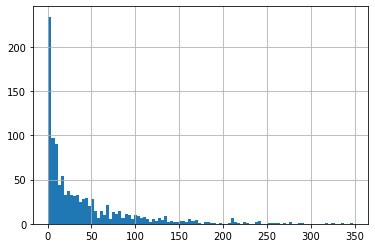

In [8]:
dataset.operator_id.value_counts().hist(bins = 100)

In [9]:
g = dataset.operator_id.value_counts() 
len(g[g > 10]) / len(g)

0.6373626373626373

In [16]:
dataset.date.nunique()

119

In [12]:
len(dataset[dataset['is_missed_call'] == True]) / len(dataset)

0.43723795035434676

## Research Objective
- Identify ineffective operators



====================================================================================================

## Ineffective Operators Definition

Ineffective Operators are characterized by the following catagories:
- Large number of missed incoming calls (internal and external)
- Long waiting time for incoming calls 
- Small number of outgoing calls (for operators making outgoing calls)

====================================================================================================

## Ineffective Operators  - Quantitative Definition

<b> Quantitaive parameters for ineffective classification:  </b>
- Each operator we will be assigned with binary value for each of the three categories by compareison to the total data. Binary values of 1 will be treated as "panlty" points, which will be used to determine the effectiveness of the operator.


<b>Determine ineffective: </b>
- <b>Sum of binary values </b> for each operator. If the result equals or greater then 2, it will be considered as ineffective.


<b> Pros and cons:</b>
- The binary approach makes for a simple, streightforward, easy to understand method. It allows us to switch the threshold values with ease for different purposes. 
- Quick identifcation of weakenss categories can be addressed to the operators. 
- Due to the fact that the binary classifcation does not weight the variance from the mean, we might choose Q1/Q3, as they set a more strict limit for detecting the worst values as ineffective. 


====================================================================================================

## Hypothesis Testing

- H0: There is no difference in call duration between effective operators (m0) and ineffective operators (m1): m0 = m1.
- h1: There is a difference in call duration between effective operators (m0) and ineffective operators (m1): m0 != m1.

====================================================================================================

## Optional - Build a ML model that predicts an observation as effective / ineffective 
  - The model will use the following features: waiting time, missed calls and tarrif_plan 
  - assumption: it is possible that tarrif plans are porioretized differently.   
  - use logistic regression for binary classification.
  - use clustering to see if the clients are truly clustered by the tarrif plan. 

====================================================================================================

## Code decomposition (road map)




### <b> Data Preprocessing </b>
   - clean/replace missing values
   - clean/replace outliar values
   - columns conversion if necessery

### <b> Exploratory Data Analysis </b>
  
  - Calculate the average waiting time for each row ( (total call duration - call duration) / calls_count )
  - add total_rows count for further precentage calculations of the tested categories.
  
  - Build a dataframe for each operator and its characteristics using groupby:
  
  
  <b>df1:</b>     
        
        operator_id | total_rows | avg_waiting_time | missing_calls_cnt | outgoing_calls_cnt 
  
based on df1, build a new dataframe and calculate the precentage of each category:
  
   <b>df2:</b>
         
        operator_id | %_missed_calls | %_outgoing_calls | avg_waiting_time
            
     
### <b> Set threshold values </b>   

  from df2:
     
  - <b>missed calls:</b> analyze missed calls distribution, use mean/median/Q3 as a threshold for inefficeny. 

  - <b>outgoing calls:</b> analyze outgoing calls distribution, use mean/median/Q3 as a threshold for ineffciency. 
  
  - <b>waiting time:</b> analyze waiting time distribution, use mean/median/Q1 as a threshold for ineffciency. 
  
  For each operator we will assign binary classiication of 1 if its category value are great then the threshold, i.e. the operator is considered ineffecient for the subjected category. 
 
 
    
### <b> Apply a row function for to determine effective/ineffective classification: </b>
   - The function will assign a binary value for each row based on the operator charcteristcs. 
   - give a final classification for operator by the sum of its total effective/ineffective binary values. If the sum equlas or larger then 2, the operator is clasified as ineffective. if the sum is 0, the operator is classified as effecive, if the sum is 1, he is considered as neither effecive/ineffctive  
 


### <b> Test Hypothesis </b>

### <b> Optional - Build a ML model that predicts a call as effective / ineffective. </b> 


- <b> missed incoming calls  </b> is considered as binary category, therefore we will compare the precetage of each operator to the precetage of the raw data. operator with missed incoming calls precentage equals or greater then the precentage of raw data- classifiy 1, below - classify 0.


- <b> waiting time  </b> is a contineous variable, therefore we will compare the numeric values of each operator to the Q3/mean/median value of the total data. operator with avearge waiting time value equals or greater then Q3/mean/median - classifiy 1, below Q3/mean/median - classify 0.


- <b> outgoing calls  </b> is considered as binary category, therefore we will compare the precetage of each operator to the total data. For operators who makes outgoing calls, if the amount is below the precentage of total data - classified as 1, above - classified as 0. 